# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки и анализа данных.
- навыки анализа и предварительной обработки данных
- визуализация данных
- работа с векторами и матрицами
- создание модели Linear Regression

Проект включает в себя:
1. Теоритическую часть: матрицы, матричное умножение
2. Создание алгоритма преобразования данных и его применение
3. Создание модели Linear Regression

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [1]:
%%html
<style>
table {float:left}
</style>

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import random
from scipy import stats as st
import warnings
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Модели машинного обучения для задач регрессии
from sklearn.linear_model import LinearRegression
# Метрики регрессии - оценка моделей
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# Для разделения данных на обучающий, валидационный, тестовый набор данных. 
from sklearn.model_selection import train_test_split, cross_val_score

## Настройка matplotlib

In [2]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [3]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [4]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [5]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

In [6]:
# вывод всех столбцов
pd.set_option('display.max_columns', None)

# Линейная алгебра

# Проект "Защита пользовательских данных"

## Описание проекта
Страховая компания нуждается в защите пользовательских данных. 
## Описание данных
Данные от страховой компании. Каждый обьект представляет информацию о пользователе страховой компании: пол, возраст, зарплата, количество членов его семьи, количество страховых выплат клиенту за последние 5 лет.

|Столбец            |Описание          | Тип столбца |
 |:---------------|:------------------------|:-----------|
 |Пол| Пол клиента страховой компании | feature |
 |Возраст| Возраст клиента| feature |
 |Зарплата | Зарплата клиента| feature |
 |Члены семьи| Количество членов семьи у клиента | feature |
 |Страховые выплаты | Количество страховых выплат клиента | target feature |

## Цель проекта 
Необходимо разработать такой метод [шифрования](https://ru.wikipedia.org/wiki/%D0%A8%D0%B8%D1%84%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5) данных, чтобы при преобразовании качество моделей машинного обучения не улучшилось.

## План работы

1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Обработка столбцов](#columnProcessing)
    - [Проверка данных на дупликаты, отрицательные значения, пропущенные значения](#dataCheck)
3. [Теоретическое доказательство](#theoryProof)
4. [Алгоритм преобразования данных](#dataEncryptAlgorithm)
    - [Создание модели](#modelCreation)
5. [Применение алгоритма](#algorithmApplication)
    - [Разделение данных](#dataSeparation)
    - [Применение оригинального алгоритма](#originalAlgorithmApplication)
        - [Модель из sklearn](#originalAlgoSklearnModel)
        - [Кастомная модель](#originalAlgoCustomModel)
    - [Применение предложенного алгоритма](#suggestedAlgorithmApplication)
        - [Модель из sklearn](#suggestedAlgoSklearnModel)
        - [Кастомная модель](#suggestedAlgoCustomModel)
6. [Результаты работы](#results)

<br>

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленный файл. Сохраним данные в соотвествующую переменную.

In [7]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)

# Словарь с именем файла и ссылкой на него
urls = {
    'insurance': ('datasets/insurance.csv', '___________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученные из файлов датафреймы в соответствующие переменные
raw_insurance_data = pd.read_csv(urls['insurance'][0],sep=',')

Напишем функцию для вывод общей информации

In [8]:
def displayGeneralDataInfo(data):
    """
    Функция для вывода общей информации
    data - данные(датафреймы)
    """
    print("Выведем первые 5 строк таблицы.")
    print()
    # вывод первых 5 строк 
    display(data.head())
    print("Выведем общую информацию ")
    print()
    # вывод общей информации
    display(data.info())
    print("Посмотрим на значения, распределения в нашем DataFrame.")
    print()
    # вывод значений, распределений в нашем DataFrame.
    display(data.describe().T)
    print("Посмотрим на корреляцию.")
    print()
    # вывод корелляции
    display(data.corr())
    print()

In [9]:
displayGeneralDataInfo(raw_insurance_data)

Выведем первые 5 строк таблицы.



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.000,49600.000,1,0
1,0,46.000,38000.000,1,1
2,0,29.000,21000.000,0,0
3,0,21.000,41700.000,2,0
4,1,28.000,26100.000,0,0


Выведем общую информацию 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

Посмотрим на значения, распределения в нашем DataFrame.



,count,mean,std,min,25%,50%,75%,max
Пол,5000.000,0.499,0.500,0.000,0.000,0.000,1.000,1.000
Возраст,5000.000,30.953,8.441,18.000,24.000,30.000,37.000,65.000
Зарплата,5000.000,39916.360,9900.084,5300.000,33300.000,40200.000,46600.000,79000.000
Члены семьи,5000.000,1.194,1.091,0.000,0.000,1.000,2.000,6.000
Страховые выплаты,5000.000,0.148,0.463,0.000,0.000,0.000,0.000,5.000


Посмотрим на корреляцию.



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000,0.002,0.015,-0.009,0.010
Возраст,0.002,1.000,-0.019,-0.007,0.651
Зарплата,0.015,-0.019,1.000,-0.030,-0.015
Члены семьи,-0.009,-0.007,-0.030,1.000,-0.036
Страховые выплаты,0.010,0.651,-0.015,-0.036,1.000


Комментарии: 
1. 5000 обьектов в датафрейме.  
2. Пропущенных значений нету. Отрицательных значений нету. 
3. Столбцы: *Пол, Возраст, Зарплата, Члены семьи, Страховые выплаты*, по которым мы будем предсказывать целевой признак. Целевой признак - *Страховые выплаты* - количество страховых выплат.
4. Столбцы записаны с заглавной буквы. Необходимо перевести столбцы к одному регистру для дальнейшей работы.

Посмотрим на распределения в данных. Напишем функцию для вывода распределения.

In [10]:
def dataDistribution(df,column,title,x_label, y_label):
    """
    Функция выводит распределения в данных
    df - dataframe, датафрейм
    column - столбец
    title - заголовок
    x_label - название оси x
    y_label - название оси y
    """
    sns.kdeplot(data=df[column], label=column, shade=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

### Возраст

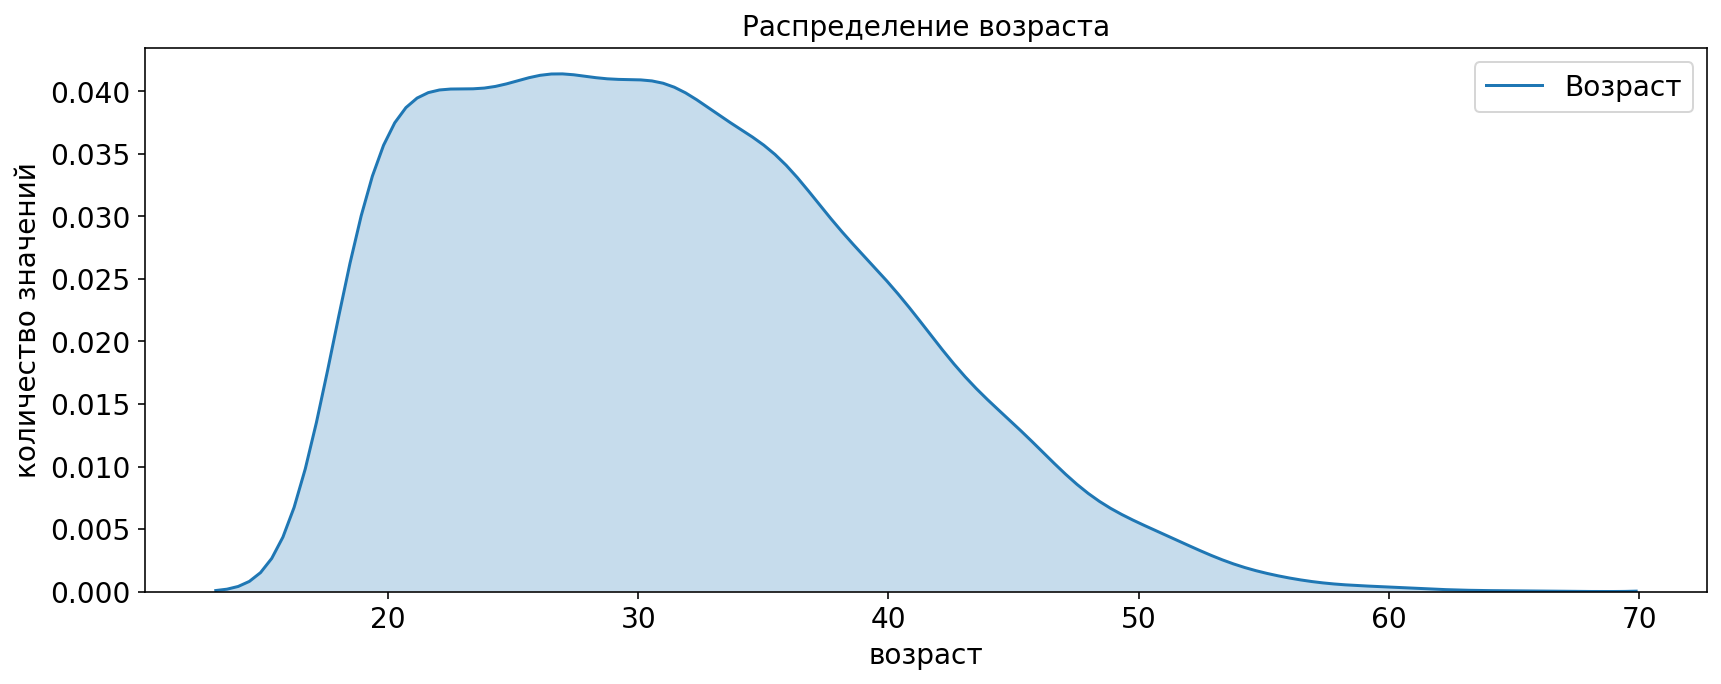

In [11]:
dataDistribution(raw_insurance_data, 'Возраст', "Распределение возраста", "возраст", "количество значений")

Большинство значений в диапазоне от 20 до 35-40 лет.

## Зарплата

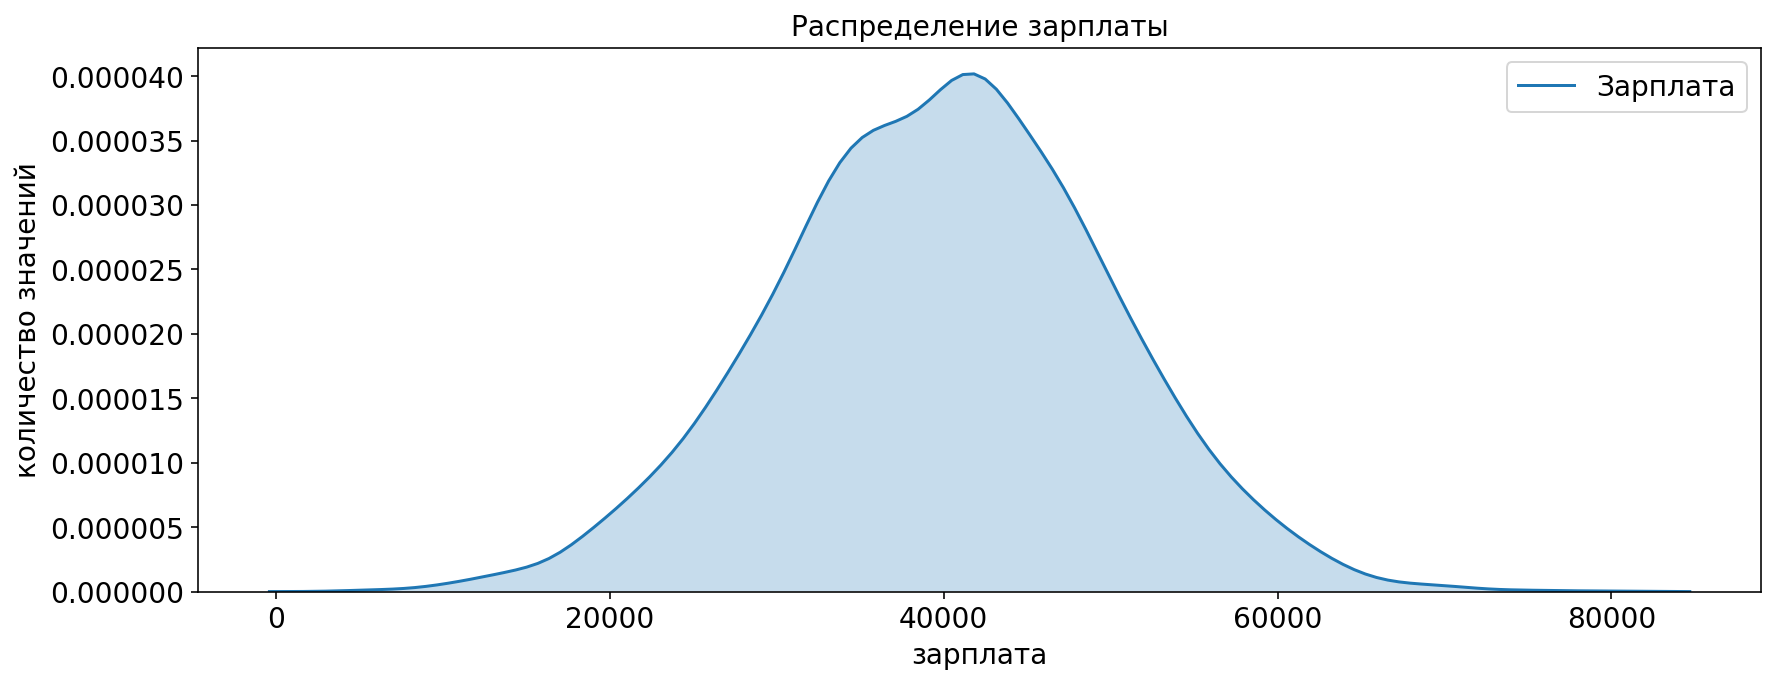

In [12]:
dataDistribution(raw_insurance_data, 'Зарплата', "Распределение зарплаты", "зарплата", "количество значений")

Мы видим нормальное распределение. В среднем, клиент получает около 40000 рублей. Большинство значений в диапазоне от 25 до 55 тыс. рублей.

## Члены семьи

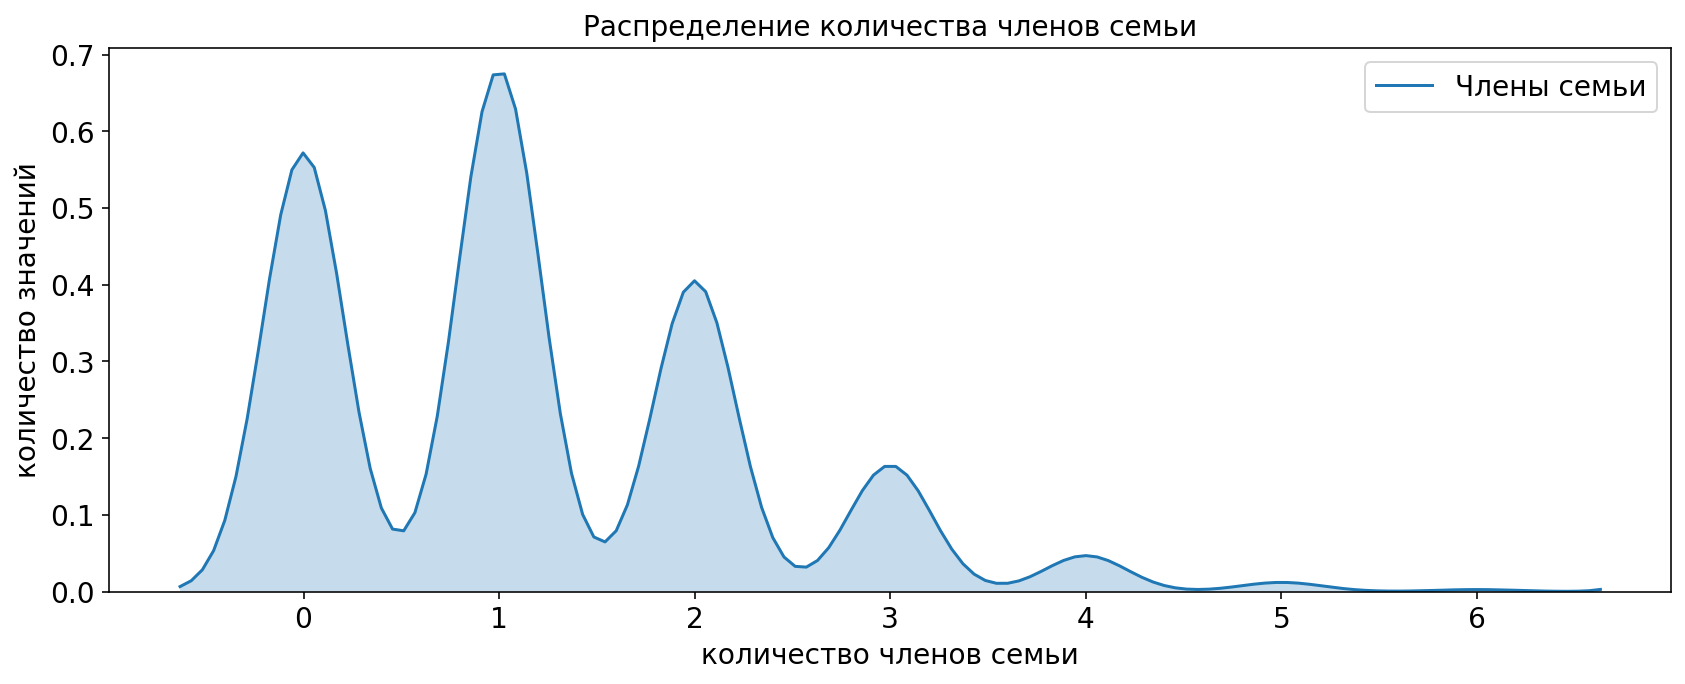

In [13]:
dataDistribution(raw_insurance_data, 'Члены семьи', "Распределение количества членов семьи", "количество членов семьи", "количество значений")

Большинство клиентов не имеют семьи, или же имеют семью,но без детей.

## Страховые выплаты

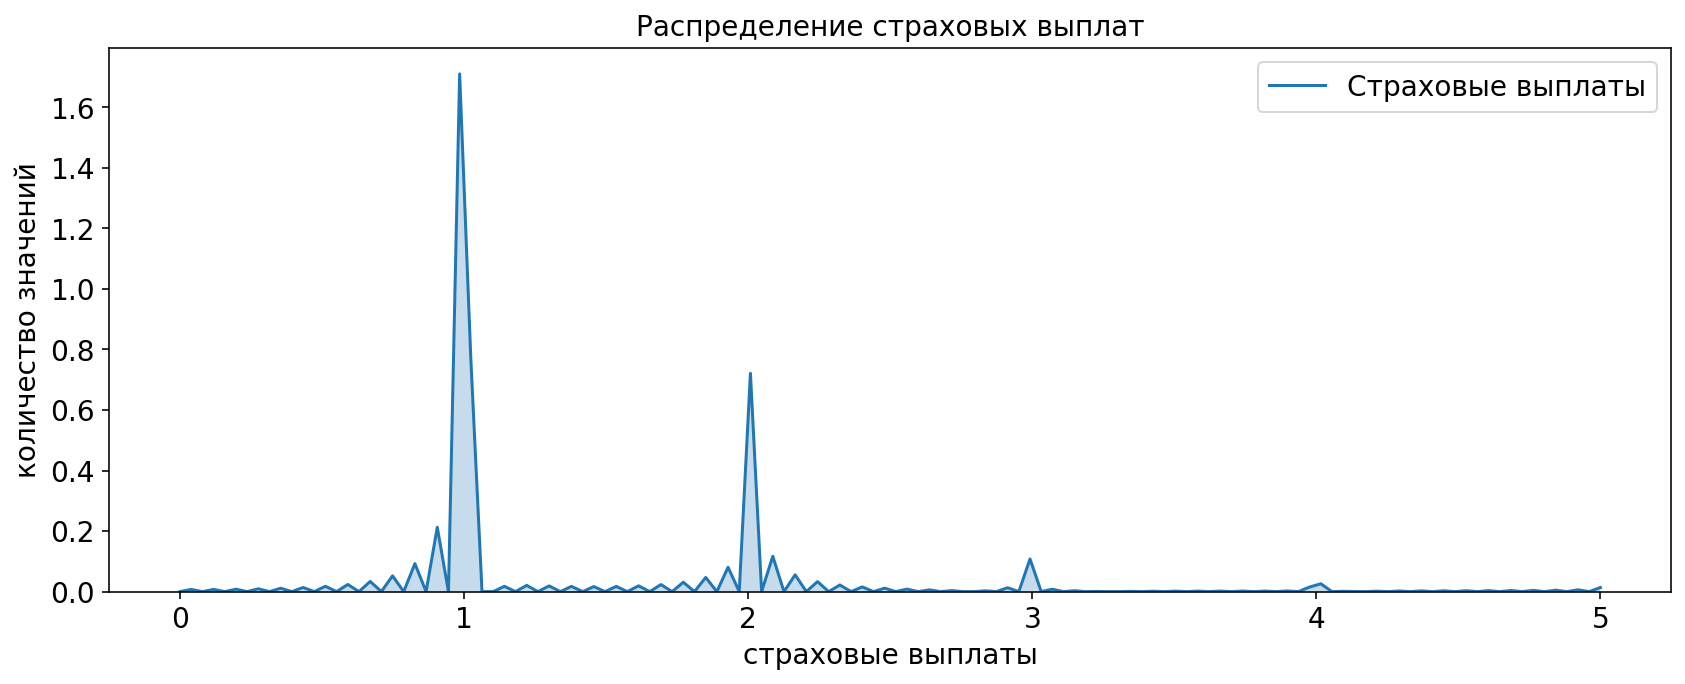

In [14]:
dataDistribution(raw_insurance_data, 'Страховые выплаты', "Распределение страховых выплат", "страховые выплаты", "количество значений")

У большинства клиентов нет страховых выплат.

## Вывод

1. 5000 обьектов в датафрейме.  
2. Пропущенных значений нету. Отрицательных значений нету. 
3. Столбцы: *Пол, Возраст, Зарплата, Члены семьи, Страховые выплаты*, по которым мы будем предсказывать целевой признак. Целевой признак - *Страховые выплаты* - количество страховых выплат.
4. Столбцы записаны с заглавной буквы. Необходимо перевести столбцы к одному регистру для дальнейшей работы.
5. Распределения:
    - Возраст: Большинство значений в диапазоне от 20 до 35-40 лет.
    - Зарплата: Мы видим нормальное распределение. В среднем, клиент получает около 40000 рублей. Большинство значений в диапазоне от 25 до 55 тыс. рублей.
    - Члены семьи: Большинство клиентов не имеют семьи или же имеют семью но без детей. 
    - Страховые выплаты: У большинства клиентов нет страховых выплат.
    
Нам необходимо: 
1. Предобработать данные:
    - Перевести все столбцы в нижний регистр
    - Поменять тип данных столбца возраст c *float* на *int*.
    - Проверить данные на пропущенные, дупликаты, отрицательные значения
2. Посмотреть если умножить матрицу признаков на обратимую матрицу, изменится ли качество линейной регрессии?
3. Предложить алгоритм преобразования данных.
4. Применить предложенный алгоритм и сравнить значения метрики *R2*.

<br>

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этапе предобработки данных, нам необходимо: 
1. Перевести все столбцы в нижний регистр
2. Проверка данных на дупликаты, отрицательные значения.

<a id="columnProcessing"></a>
## Обработка столбцов

Переведём все наименования столбцов в нижний регистр. Напишем функцию.

In [15]:
def snake_case(s):
    """
    Преобразование строк из camelCase в snake_case.
    s - строка имя столбца
    """
    return ''.join('_' + c.lower()
                   if all([i != 0,
                           c.isupper(),
                           s[i - 1].islower()])
                   else c.lower()
                   for i, c in enumerate(s))

In [16]:
# Преобразуем колонки в snake_case
raw_insurance_data.columns = map(snake_case, raw_insurance_data.columns)
raw_insurance_data.columns

Index(['пол', 'возраст', 'зарплата', 'члены семьи', 'страховые выплаты'], dtype='object')

Столбцы переведены, проведём проверку данных.

<a id="dataCheck"></a>
## Проверка данных на дупликаты, отрицательные значения, пропущенные значения.

Напишем функцию которая проверит:
1. Пропущенные значения
2. Дупликаты
3. Есть ли отрицательные значения
4. Соответствующие типы данных float64,int64

In [17]:
def get_preprocessed_data(raw_data):
    """
    Функция проверяет данные. Возвращает предобработанные данные для обучения.
    raw_data - данные для проверки
    """
    # проверяем данные
    assert raw_data.isna().sum().sum() == 0, 'В данных не должно быть пропущенных значений!'
    assert raw_data.select_dtypes(exclude=[np.float64,np.int64]).size == 0, 'Данные должны иметь только численный тип данных!'
    assert raw_data.duplicated().sum().sum() == 0, 'В данных не должно быть дупликатов!'
    assert raw_data.min().min() == 0,'В данных не должно быть отрицательных значений!'
    print('Данные проверку прошли!')
    #создаем копию оригинального датафрейма
    preprocessed_data = raw_data.copy()
    
    try:
        preprocessed_data['возраст'] = preprocessed_data['возраст'].astype('int')
    except:
        print('Check for missing values. Data type - NaN can not be converted to int')
    
    return preprocessed_data

In [18]:
# insurance_data = get_preprocessed_data(raw_insurance_data)
# появились дупликаты

Посмотритм дупликаты.

In [19]:
raw_insurance_data.duplicated().sum()

153

153 обьекта - дупликатов. Удалим их методом *drop_duplicates()*.

In [20]:
raw_insurance_data = raw_insurance_data.drop_duplicates().reset_index(drop=True)

In [21]:
insurance_data = get_preprocessed_data(raw_insurance_data)

Данные проверку прошли!


Посмотрим сколько обьектов у нас осталось.

In [22]:
print(f'Количество обьектов: {insurance_data.shape[0]}')

Количество обьектов: 4847


## Вывод

На этапе предобработки данных, мы:
1. Перевели все столбцы в нижний регистр
2. Проверили данные на пропущенные значения, дупликаты, отрицательные значения. Обнаружилось 153 обьекта -  дупликатов. Удалили дупликаты. Данные проверку прошли.
3. Количество обьектов: 4847

<br>

<a id="theoryProof"></a>
# Этап 3 - Теоретическое доказательство

На этом этапе необходимо проверить: если умножить матрицу признаков на обратимую матрицу, изменится ли качество линейной регрессии? 

Для линейной регрессии необходимо найти параметры модели, при которых значение функции потерь (*loss function*) на обучающей выборке минимально. Формула задачи обучения линейной регрессии для функции потерь (*loss function*): 

\begin{equation} w=argminMSE(Xw, y) \end{equation}

Минимальное значение *MSE* получается, когда веса равны этой величине:  

\begin{equation} w=(X^{T}*X)^{-1}*X^{T}*y \end{equation}

- Транспонированная матрица признаков умножается на себя. 
- Вычисляется обратная к результату матрица.
- Полученная обратная матрица умножается на транспонированную матрицу признаков.
- Результат умножается на вектор значений целевого признака

Матрица **А** со степенью *-1* называется **обратной** к квадратной матрице **A**, если выполняются равенства:

\begin{equation} AA^{-1} = A^{-1}A = E \end{equation}

Квадратными матрицы, для которых можно найти обратные, называются *обратимые*. Необратимые матрицы встречаются редко.

Если сгенерировать случайную матрицу функцией *np.random().normal()*. Вероятность получить необратимую матрицу близка к 0. Пример:

In [23]:
# Генерируем случайную квадратную матрицу
matrix_example = np.random.normal(size=(3,3))
matrix_example

array([[ 1.96238859, -1.5987327 , -1.12130383],
       [-2.37879549,  0.67447175,  1.28956392],
       [-0.47986604,  0.24903607, -1.09256396]])

In [24]:
# Находим обратную матрицу
matrix_example_invert = np.linalg.inv(matrix_example)
matrix_example_invert

array([[-0.31401303, -0.6012739 , -0.38741633],
       [-0.95499366, -0.79600826,  0.04057841],
       [-0.07976071,  0.0826461 , -0.7358714 ]])

Проверим:

\begin{equation} AA^{-1} = A^{-1}A = E \end{equation}

In [25]:
identity_matrix = np.dot(matrix_example, matrix_example_invert)
identity_matrix

array([[ 1.00000000e+00,  1.69340733e-16, -1.73383890e-17],
       [ 3.44066301e-17,  1.00000000e+00,  2.04920933e-17],
       [ 1.51420568e-17, -4.10309434e-18,  1.00000000e+00]])

Пусть переменная ***P*** будет нашей обратимой матрицей. Нам необходимо доказать: 

\begin{equation} MSE(X*w, y) = MSE(X*P*w_1, y) \end{equation}

**w** левой стороны равенства:

\begin{equation} w=(X^{T}*X)^{-1}*X^{T}*y \end{equation}

**w1** правой стороны равенства: 

\begin{equation} w_1=((X*P)^{T}*(X*P))^{-1}(X*P)^{T}*y \end{equation}

Раскрываем скобки **w1**, при условиях:
1. **X** и **P** должны быть квадртными
2. $(XP)^T=P^TX^T$ Транспонированное произведение матриц равно произведению транспонированных матриц
3. $(XP)^{-1}=P^{-1}X^{-1}$ Обратная матрица от произведения двух матриц равна обратной матрицы P(второй) к обратной матрице X(первой)

\begin{equation} w_1=((P^T*X^T) * (X * P))^{-1} * P^T*X^T * y \end{equation}

\begin{equation} w_1=(X * P)^{-1} * (P^T*X^T)^{-1} * P^T*X^T * y \end{equation}

\begin{equation} w_1= P^{-1} * X^{-1} * (X^T)^{-1} * (P^T)^{-1} * P^T*X^T * y \end{equation}

По свойству: $(XP)^{-1}=P^{-1}X^{-1}$ обратная матрица от произведения двух матриц равна обратной матрицы B(второй) к обратной матрице А(первой), сделаем преобразование.

\begin{equation} w_1= P^{-1}  * (X^T*X)^{-1} * (P^T)^{-1} * P^T*X^T * y \end{equation}

Перестановим множители

\begin{equation} w_1= (X^T*X)^{-1} * X^T * y * P^{-1} * (P^T)^{-1} * P^T \end{equation}

Мы знаем что:

\begin{equation} w=(X^{T}*X)^{-1}*X^{T}*y \end{equation}

Подставим в наше уравнение и получим такой результат:

\begin{equation} w_1= (X^T*X)^{-1} * X^T * y * P^{-1} * (P^T)^{-1} * P^T \end{equation}

\begin{equation} w_1= w * P^{-1} * (P^T)^{-1} * P^T  \end{equation}

Основываясь на:

$PP^{-1} = P^{-1}P = E$ умножение матрицы на свою обратную - есть единичная матрица.

$(P^T)^{-1} = (P^{-1})^T$ транспортированная оратная матрица есть обратная матрица транспортированная

$(XP)^T=P^TX^T$ Транспонированное произведение матриц равно произведению транспонированных матриц


Преобразуем наше уравнение

\begin{equation} w_1= w*(P^{T})^{-1}*P^{T}*P^{-1} \end{equation}
\begin{equation} w_1= w*(P^{-1})^{T}*P^{T}*P^{-1} \end{equation}
\begin{equation} w_1= w*(P*P^{-1})^{T}*P^{-1} \end{equation}
\begin{equation} w_1= w*(E)^{T}*P^{-1} \end{equation}

$E^T = E$ Результатом транспонирования единичной матрицы Е является единичная матрица Е. 

$AE = EA = A$ Если любую матрицу A умножить на единичную (или наоборот), получится эта же матрица A

\begin{equation} w_1= w*P^{-1} \end{equation}

Подставим в наше первое равенство

\begin{equation} MSE(X*w, y) = MSE(X*P*w*P^{-1}, y) \end{equation}

Перестановим множители

\begin{equation} MSE(X*w, y) = MSE(X*P*P^{-1}*w, y) \end{equation}

Также, основываясь на:

$PP^{-1} = P^{-1}P = E$ умножение матрицы на свою обратную - есть единичная матрица.

$AE = EA = A$ Если любую матрицу A умножить на единичную (или наоборот), получится эта же матрица A

Преобразуем уравнение

\begin{equation} MSE(X*w, y) = MSE(X*E*w, y) \end{equation}

\begin{equation} MSE(X*w, y) = MSE(X*w, y) \end{equation}

Мы доказали, что ,умножив матрицу признаков на обратимую матрицу, качество модели не измениться.

## Вывод

На этом этапе мы проверили: если умножить матрицу признаков на обратимую матрицу, изменится ли качество линейной регрессии? 

Мы доказали, что, **умножив матрицу признаков на обратимую матрицу, качество модели не измениться**.

<br>

<a id="dataEncryptAlgorithm"></a>
# Этап 4 - Алгоритм преобразования данных

На этом этапе нам необходимо создать алгоритм преобразования данных.

Ранее мы узнали, что **качество модели не измениться, умножив матрицу признаков на обратимую матрицу**.

Следовательно, предложим алгоритм с [симметричным шифрированием](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BC%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%BD%D1%8B%D0%B5_%D0%BA%D1%80%D0%B8%D0%BF%D1%82%D0%BE%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B):
1. Генерируем ключ (нашу обратимую матрицу)
2. Умножаем матрицу признаков на полученный ключ(обратимую матрицу)
3. Создаем модель Линейной регрессии
4. Тренируем модель на полученной матрице
5. Делаем предсказание
6. Смотрим на метрику *r2_score()* и полученный w вектор весов + w0 сдвиг предсказания

Для сравнения, предложим оригинальный алгоритм без умножения на обратимую матрицу: 
1. Создаем модель Линейной регрессии
2. Тренируем модель, не изменяя матрицу признаков
3. Делаем предсказания
4. Смотрим на метрику *r2_score()* и w вектор весов + w0 сдвиг предсказания

<a id="modelCreation"></a>
## Создание модели

Создадим нашу модель Линейной Регрессии. Сравним ее с моделью из библиотеки *sklearn*.

In [27]:
class LinearRegressionCustom:
    def fit(self, train_features, train_target):
        """
        Метод обучения модели
        self - обьект класса
        train_features - матрица признаков
        train_target - вектор целевого признака
        """
        # добавляем столбец состоящий из только единиц
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features),axis=1)
        y = train_target
        # функция потерь (loss function)
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        # сохраняем значения w - вектор весов
        self.w = w[1:]
        # сдвиг предсказания
        self.w0 = w[0]
    
    def predict(self, features):
        """
        Метод предсказания модели. Метод возвращает вектор предсказаний
        self -  обьект класса
        features - матрица признаков 
        """
        return features.dot(self.w) + self.w0

## Вывод

Основываясь на выводе, что **качество модели не измениться, умножив матрицу признаков на обратимую матрицу одинакового размера**, мы предложили алгоритм преобразования данных. Кроме того, мы создали нашу кастомную модель Линейной Регрессии. 

<br>

<a id="algorithmApplication"></a>
# Этап 5 - Применение алгоритма

На этом этапе нам необходимо применить предложенный алгоритм и посмотреть измениться ли качество модели от преобразований или нет. Кроме того, сравним нашу кастомную модель с модель из библиотеки *sklearn*.

<a id="dataSeparation"></a>
## Разделение данных 

Напишем функцию разделения целевого признака от остальных.

In [28]:
def target_features_split(data,column):
    """
    Функция разделяет данные на целевой признак и признаки. Функция возвращает 1) целевой признак, 2) признаки без целевого
    data - данные которые необходимо разделить.
    column - целевой признак
    """
    return data[column], data.drop(column,axis=1)

In [29]:
train_target,train_features = target_features_split(insurance_data, 'страховые выплаты')

<a id="originalAlgorithmApplication"></a>
## Применение оригинального алгоритма

<a id="originalAlgoSklearnModel"></a>
### Модель из sklearn

In [30]:
# создаем модель
model_1 = LinearRegression()
# обучаем модель
model_1.fit(train_features, train_target)
# предсказания модели
model_1_pred = model_1.predict(train_features)
model_1_r2_score = r2_score(train_target,model_1_pred)
print(f'Метрика r2_score: {model_1_r2_score}')
print(f'Вектор весов w: {model_1.coef_}')
print(f'Cдвиг w0 {model_1.intercept_}')

Метрика r2_score: 0.4302010044852067
Вектор весов w: [ 9.46018141e-03  3.61640081e-02 -1.38991363e-07 -1.42517371e-02]
Cдвиг w0 -0.9517099946522036


<a id="originalAlgoCustomModel"></a>
### Кастомная модель

In [31]:
# создаем модель
model_2 = LinearRegressionCustom()
# обучаем модель
model_2.fit(train_features, train_target)
# предсказания модели
model_2_pred = model_2.predict(train_features)
model_2_r2_score = r2_score(train_target,model_2_pred)
print(f'Метрика r2_score: {model_2_r2_score}')
print(f'Вектор весов w: {model_2.w}')
print(f'Cдвиг w0 {model_2.w0}')

Метрика r2_score: 0.4302010044852068
Вектор весов w: [ 9.46018141e-03  3.61640081e-02 -1.38991363e-07 -1.42517371e-02]
Cдвиг w0 -0.95170999465196


Наша модель работает также как и модель из библиотеки *sklearn*!

<a id="suggestedAlgorithmApplication"></a>
## Применение предложенного алгоритма

Сгенерируем случайную матрицу функцией *np.random().normal()*. Вероятность получить необратимую матрицу близка к 0.

In [32]:
# Генерируем случайную квадратную матрицу
size = train_features.shape[1]
key = np.random.normal(size=(size,size))
# Умножаем матрицу признаков на сгенерированную матрицу
train_features_encrypted = train_features.dot(key)

Проверяем зашифрованные данные

In [33]:
train_features_encrypted.head()

,0,1,2,3
0,9813.238,-67140.278,-11231.966,21064.253
1,7491.968,-51433.005,-8608.897,16144.752
2,4133.285,-28421.722,-4758.586,8924.063
3,8275.356,-56453.026,-9440.768,17702.710
4,5151.896,-35326.765,-5911.323,11087.298


Посмотрим на данные до шифрования и после. Попробуем восстановить зашифрованные данные с помощью ключа.

**До шифрования**

In [34]:
train_features.head()

,пол,возраст,зарплата,члены семьи
0,1,41,49600.000,1
1,0,46,38000.000,1
2,0,29,21000.000,0
3,0,21,41700.000,2
4,1,28,26100.000,0


**После шифрования**

In [35]:
train_features_encrypted.head()

,0,1,2,3
0,9813.238,-67140.278,-11231.966,21064.253
1,7491.968,-51433.005,-8608.897,16144.752
2,4133.285,-28421.722,-4758.586,8924.063
3,8275.356,-56453.026,-9440.768,17702.710
4,5151.896,-35326.765,-5911.323,11087.298


Чтобы расшифровать признаки, умножим на обратную матрицу ключа

In [36]:
# находим обратну матрицу
key_inv = np.linalg.inv(key)
# умножаем матрицу зашифрованных признаков на обратную матрицу ключа
train_features_decrypted = train_features_encrypted.dot(key_inv)
train_features_decrypted.head()

,0,1,2,3
0,1.000,41.000,49600.000,1.000
1,-0.000,46.000,38000.000,1.000
2,0.000,29.000,21000.000,-0.000
3,-0.000,21.000,41700.000,2.000
4,1.000,28.000,26100.000,-0.000


Как видим, данные восстановились. Перейдём к применению

<a id="suggestedAlgoSklearnModel"></a>
### Модель из sklearn

In [37]:
# создаем модель
model_3 = LinearRegression()
# обучаем модель
model_3.fit(train_features_encrypted, train_target)
# предсказания
model_3_pred = model_3.predict(train_features_encrypted)
model_3_r2_score = r2_score(train_target,model_3_pred)
print(f'Метрика r2_score: {model_3_r2_score}')
print(f'Вектор весов w: {model_3.coef_}')
print(f'Cдвиг w0 {model_3.intercept_}')

Метрика r2_score: 0.4302010044852095
Вектор весов w: [-0.02075655 -0.00342603  0.01605099  0.00737834]
Cдвиг w0 -0.9517099946525505


<a id="suggestedAlgoCustomModel"></a>
### Кастомная модель

In [38]:
# создаем модель 
model_4 = LinearRegressionCustom()
# обучаем модель
model_4.fit(train_features_encrypted, train_target)
# предсказания
model_4_pred = model_4.predict(train_features_encrypted)
model_4_r2_score = r2_score(train_target,model_4_pred)
print(f'Метрика r2_score: {model_4_r2_score}')
print(f'Вектор весов w: {model_4.w}')
print(f'Cдвиг w0 {model_4.w0}')

Метрика r2_score: 0.4302010044852004
Вектор весов w: [-0.02075655 -0.00342604  0.01605098  0.00737833]
Cдвиг w0 -0.9517099513049412


<a id="summary"></a>
## Итоги

Метрики r2, векторы весов и сдвиг предсказаний моделей без шифрования данных

Напишем функцию для вывода

In [39]:
def results(model, r2_score, title, isCustom):
    """
    Функция для вывода результатов
    model - модель
    r2_score - точность по метрике R2
    title - заголовок
    isCustom - кастомная ли модель
    """
    if (isCustom):
        print(title)
        print(f'Метрика r2_score: {r2_score}')
        print(f'Вектор весов w: {model.w}')
        print(f'Сдвиг w0: {model.w0}')
    else:
        print(title)
        print(f'Метрика r2_score: {r2_score}')
        print(f'Вектор весов w: {model.coef_}')
        print(f'Сдвиг w0: {model.intercept_}')

In [40]:
results(model_1, model_1_r2_score, "Модель sklearn без шифрования данных", False)

Модель sklearn без шифрования данных
Метрика r2_score: 0.4302010044852067
Вектор весов w: [ 9.46018141e-03  3.61640081e-02 -1.38991363e-07 -1.42517371e-02]
Сдвиг w0: -0.9517099946522036


In [41]:
results(model_2, model_2_r2_score, "Кастомная модель без шифрования данных", True)

Кастомная модель без шифрования данных
Метрика r2_score: 0.4302010044852068
Вектор весов w: [ 9.46018141e-03  3.61640081e-02 -1.38991363e-07 -1.42517371e-02]
Сдвиг w0: -0.95170999465196


In [42]:
results(model_3,model_3_r2_score, "Модель sklearn с шифрованием данных", False)

Модель sklearn с шифрованием данных
Метрика r2_score: 0.4302010044852095
Вектор весов w: [-0.02075655 -0.00342603  0.01605099  0.00737834]
Сдвиг w0: -0.9517099946525505


In [43]:
results(model_4, model_4_r2_score, "Кастомная модель с шифрованием данных", True)

Кастомная модель с шифрованием данных
Метрика r2_score: 0.4302010044852004
Вектор весов w: [-0.02075655 -0.00342604  0.01605098  0.00737833]
Сдвиг w0: -0.9517099513049412


Как видим:
- Качество моделей не изменилось, метрика r2 практически одинакова.
- Вектора весов разные
- Наша кастомная модель работает как и модель из библиотеки sklearn

## Вывод

На этом этапе мы: 
1. Применили предложенный алгоритм:
    - Посмотрели на данные до шифрования и после. Данные зашифровались.
    - Попробовали восстановить зашифрованные данные с помощью ключа. Данные восстановились.
2. Посмотрели измениться ли качество модели от преобразований или нет:
    - Качество моделей не изменилось, метрика r2 практически одинакова.
    - Вектора весов разные.
3. Сравнили нашу кастомную модель с модель из библиотеки sklearn:
    - Наша кастомная модель работает как и модель из библиотеки sklearn.

<br>

<a id="results"></a>
# Этап 6 - Результаты работы

В ходе проекта мы успешно разработали метод [шифрования](https://ru.wikipedia.org/wiki/%D0%A8%D0%B8%D1%84%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5) данных, чтобы при преобразовании качество моделей машинного обучения не улучшилось. Тем самым помогли страховой компании защитить данные пользователей. 
1. Предобработали данные:
    - Перевели все столбцы в нижний регистр
    - Проверили данные на пропущенные значения, дупликаты, отрицательные значения. Обнаружилось 153 обьекта - дупликатов. Удалили дупликаты. Данные проверку прошли.
    - Количество обьектов: 4847
2. Посмотрели изменится ли качество линейной регрессии, если умножить матрицу признаков на обратимую матрицу:
    - С помощью теории, мы доказали, что, **умножив матрицу признаков на обратимую матрицу, качество модели не измениться**.
3. Предложили алгоритм преобразования данных:
    1. Генерируем ключ (нашу обратимую матрицу)
    2. Умножаем матрицу признаков на полученный ключ(обратимую матрицу)
    3. Создаем модель Линейной регрессии
    4. Тренируем модель на полученной матрице
    5. Делаем предсказание
    6. Смотрим на метрику *r2_score()* и полученный w вектор весов + w0 сдвиг предсказания
4. Мы создали нашу кастомную модель Линейной Регрессии. 
5. Применили предложенный алгоритм и сравнили значения метрики *R2*:
    - Посмотрели на данные до шифрования и после. Данные зашифровались.
    - Попробовали восстановить зашифрованные данные с помощью ключа. Данные восстановились.
    - Качество моделей не изменилось, метрика r2 практически одинакова.
    - Вектора весов разные.
    
